In [132]:
# System management 
import os
import time
import pickle
import dill
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd
import re
pd.options.display.max_rows = 400

# Scikit-learn
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.preprocessing import StandardScaler 
from sklearn.feature_selection import RFECV

# Predictive Models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials
from hyperopt.pyll.base import scope

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular
import shap

# MLFlow tracking
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Data drift
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
#import seaborn as sns
plt.style.use('fivethirtyeight')
plt.style.use('fivethirtyeight')
plt.rcParams.update(
    {
     'xtick.labelsize':25,
     'ytick.labelsize':25,
     'axes.labelsize': 25,
     'legend.fontsize': 25,
     'axes.titlesize':45,
     'axes.titleweight':'bold',
     'axes.titleweight':'bold'
    })
%matplotlib inline
sns.set_theme(palette='Set1')

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

In [82]:
# Set main directory
project_path = '/Users/felipelima/alternance/projets/credit-scoring/'
os.chdir(project_path)

In [83]:
# Load data
data = pd.read_csv('data/processed/train_feature_engineering.csv', index_col=[0])
#data_test = pd.read_csv('data/processed/test_feature_engineering.csv', index_col=[0])

#### MLFlow 

Set MLFlow tracking

In [84]:
# Create experiment
experiment_name = 'credit_scoring'
# Check if the experiment exists
experiment = mlflow.get_experiment_by_name(experiment_name)
# If the experiment doesn't exist, create it
if experiment is None: 
    mlflow.create_experiment(experiment_name)
# Set the experiment 
mlflow.set_experiment(experiment_name)
mlflow.end_run()

In [85]:
# Function to log model to mlflow
def log_mlflow(model, name, params, business_score, roc_auc=None, f1_score=None, accuracy=None, 
               precision=None, recall=None, specificity=None, fpr=None, fitting_time=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag('mlflow.runName', name)

        # Set parameters
        for param, value in params.items():
            mlflow.log_param(param, value)

        # Set metrics
        mlflow.log_metric('Business score', business_score)
        mlflow.log_metric('AUC', roc_auc)
        mlflow.log_metric('F1', f1_score)
        mlflow.log_metric('Accuracy', accuracy)
        mlflow.log_metric('Precision', precision)
        mlflow.log_metric('Recall', recall)
        mlflow.log_metric('Specificity', specificity)
        mlflow.log_metric('False positive rate', fpr)
        mlflow.log_metric('Fitting time', fitting_time)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

#### Data pre-processing

In [86]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET]
features = data.drop(columns=TARGET)
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

##### Missing values

Fill the missing values with a simple imputer

In [87]:
# Check missing values
nan_values = data.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 32442173 (18.35%)


In [88]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)
features_fill = pd.DataFrame(features_fill, columns=features_names)

In [89]:
nan_values = features_fill.isna().sum().sum()
print('Missing values = {} ({:.2%})'.format(nan_values, nan_values/data.size))

Missing values = 0 (0.00%)


#### Split data

In [90]:
# Split dataset (filled)
x_train, x_val, y_train, y_val = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(246004, 574) (246004,)
(61502, 574) (61502,)


#### Data distribution

In [91]:
y_train_counter = Counter(y_train)
y_val_counter = Counter(y_val)
print('Training target statistics:', y_train_counter)
print('Testing target statistics:', y_val_counter)

# Print ratio
print('Ratio is 1:{:.0f} in training set'.format(y_train_counter[0] / y_train_counter[1]))
print('Ratio is 1:{:.0f} in validation set'.format(y_val_counter[0] / y_val_counter[1]))

Training target statistics: Counter({0.0: 226154, 1.0: 19850})
Testing target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in training set
Ratio is 1:11 in validation set


In [92]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print('Training target statistics:', Counter(y_res))
print('Ratio is 1:{:.0f} in training set'.format(Counter(y_res)[0] / Counter(y_res)[1]))
print('Validation target statistics:', Counter(y_val))
print('Ratio is 1:{:.0f} in validation set'.format(Counter(y_val)[0] / Counter(y_val)[1]))

Training target statistics: Counter({0.0: 113077, 1.0: 113077})
Ratio is 1:1 in training set
Validation target statistics: Counter({0.0: 56527, 1.0: 4975})
Ratio is 1:11 in validation set


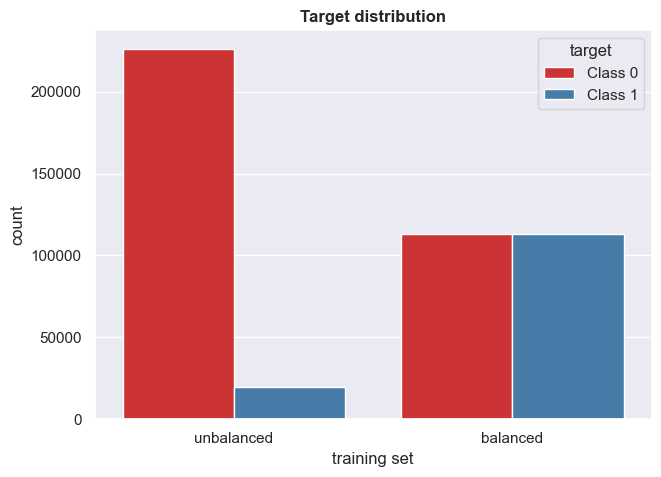

In [93]:
# Display barplot of distribution
class_distr_df = pd.DataFrame({'training set': ['unbalanced', 'unbalanced', 'balanced', 'balanced'],
                               'target': ['Class 0', 'Class 1', 'Class 0', 'Class 1'],
                               'count': [y_train_counter[0], y_train_counter[1], Counter(y_res)[0], Counter(y_res)[1]]})

# Display barplot
sns.barplot(class_distr_df, x='training set', y='count', hue='target')
plt.title('Target distribution')
plt.show()

The resulting data is now balanced. However, since we will test using cross validation, the resampling step shall be done for each cross validation iteration.

#### Metric functions

In [94]:
# 1 --> dont repay
# 0 --> repay
# Custom loss function based on business rule =  
# cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)
def businness_loss_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (10 * fn + fp) / (10 * fn + tn + fp)
    score = 1 - cost
    return score
business_scorer = make_scorer(businness_loss_func, greater_is_better=True)

def specificity_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)
    return specificity
specificity_scorer = make_scorer(specificity_score_func)

def false_positive_rate_score_func(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn)
    return fpr
fpr_scorer = make_scorer(false_positive_rate_score_func)

#### Classification

In [95]:
def plot_cf_matrix_roc_curve(y_true, y_pred, y_pred_proba, feature_importance=None):
    fig = plt.figure(figsize=(20,15))
    # Left subplot - Confusion Matrix
    plt.subplot(221)
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')

    # Right subplot - ROC curve
    plt.subplot(222)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='orange', linewidth=5, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

In [135]:
def train_model_with_cross_val(model, X = features_fill, y = target, cv=2, param_distributions = None):
    # Remove special caracters from column name --> lightgbm
    X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

    # Calculate various evaluation metrics
    results_cv = {}
    results_val = {}

    # Define your scoring metrics
    scoring = {
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'specificity': specificity_scorer,
            'fpr': fpr_scorer,
            'business': business_scorer
    }

    # Split data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

    # Set pipeline with oversampling and undersampling
    pipeline = Pipeline([
                ('over', SMOTE(sampling_strategy=0.5, random_state=RANDOM_STATE)), 
                ('under', RandomUnderSampler(sampling_strategy=1, random_state=RANDOM_STATE)), 
                ('classifier', model)
    ])

    # Create a cross-validation generator
    strat_kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)

    if param_distributions is not None:
        # Perform hyperparameter tuning using GridSearchCV
        randomized_search = RandomizedSearchCV(pipeline, param_distributions, cv=strat_kf, scoring=business_scorer, n_iter=10, n_jobs=-1, random_state=RANDOM_STATE)
        t0 = time.time()
        randomized_search.fit(x_train, y_train)
        results_val['fitting_time'] = time.time() - t0
        best_model = randomized_search.best_estimator_
        results_cv = randomized_search.cv_results_
    else:
        # Record the start time
        start_time = time.time() 

        # Perform cross-validation without hyperparameter tuning
        scores = cross_validate(pipeline, x_train, y_train, cv=strat_kf, scoring=scoring, n_jobs=-1)
        for score in scoring.keys():
            results_cv[score] = scores[f'test_{score}']
        best_model = pipeline

        # Record the final time        
        end_time = time.time()
        results_cv['execution_time'] = end_time - start_time

        # Fit / train best model with training set
        t0 = time.time()
        best_model.fit(x_train, y_train)
        results_val['fitting_time'] = time.time() - t0

    # Predict on the test set
    y_pred = best_model.predict(x_val)
    y_pred_proba = best_model.predict_proba(x_val)[:, 1]

    # Calculate validation metrics 
    results_val['accuracy'] = accuracy_score(y_val, y_pred)
    results_val['precision'] = precision_score(y_val, y_pred)
    results_val['recall'] = recall_score(y_val, y_pred)
    results_val['f1'] = f1_score(y_val, y_pred)
    results_val['roc_auc'] = roc_auc_score(y_val, y_pred_proba)
    results_val['specificity'] = specificity_score_func(y_val, y_pred)
    results_val['fpr'] = false_positive_rate_score_func(y_val, y_pred)
    results_val['business'] = businness_loss_func(y_val, y_pred)
    
    plot_cf_matrix_roc_curve(y_val, y_pred, y_pred_proba)

    if param_distributions is not None: 
        return best_model, results_cv, results_val, randomized_search
    else: 
        return best_model, results_cv, results_val

#### Modelling

##### DummyClassifier (= baseline 0)

CPU times: user 1 µs, sys: 1e+03 ns, total: 2 µs
Wall time: 6.91 µs


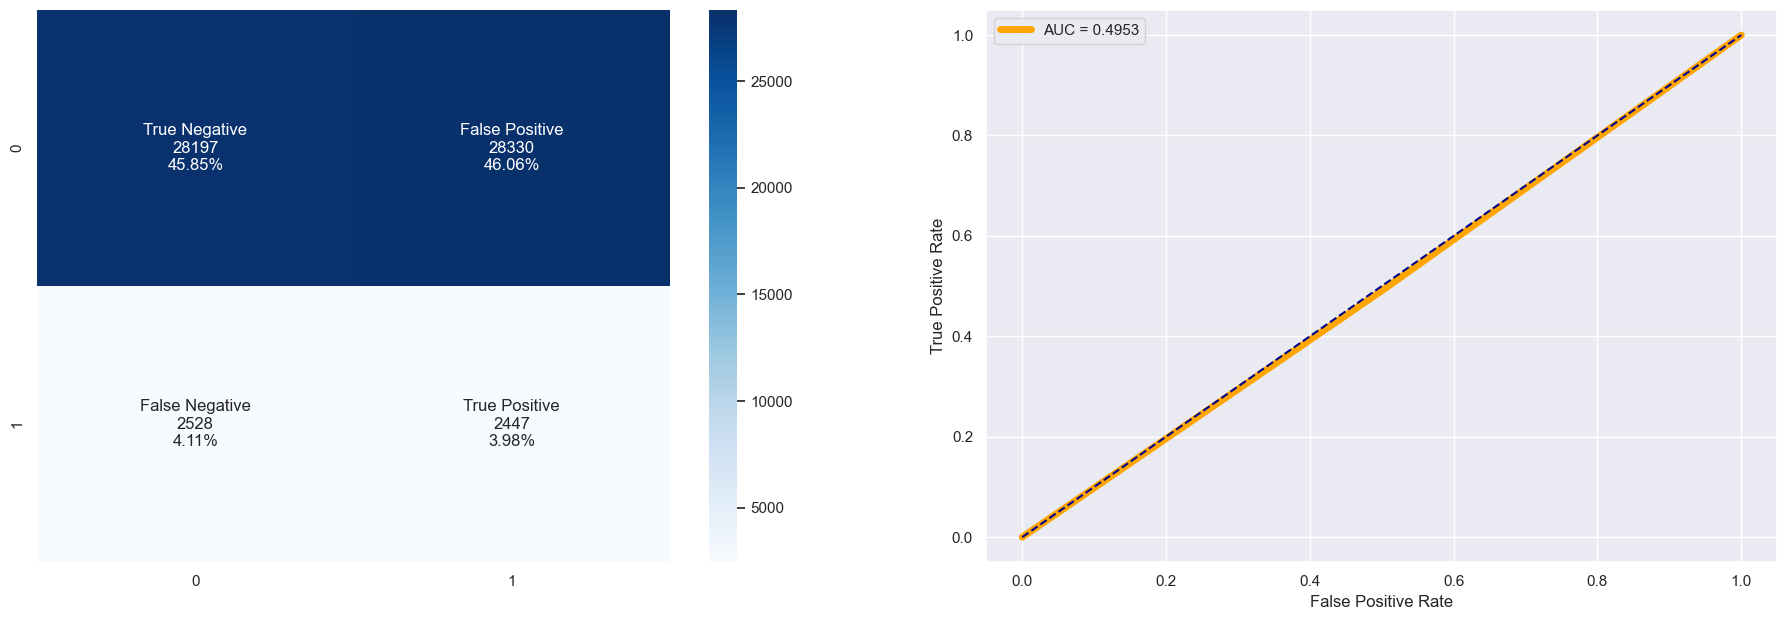

In [97]:
%time
# Create logistic regression model
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Compute results 
dc_model, dc_results_cv, dc_results_val = train_model_with_cross_val(dc)

# Save logs
log_mlflow(dc_model, dc_name, params=dc_model.named_steps['classifier'].get_params(), business_score=dc_results_val['business'], 
           roc_auc=dc_results_val['roc_auc'], f1_score=dc_results_val['f1'], accuracy=dc_results_val['accuracy'],
           precision=dc_results_val['precision'], recall=dc_results_val['recall'], specificity=dc_results_val['specificity'],
           fpr=dc_results_val['fpr'], fitting_time=dc_results_val['fitting_time'])

##### Logistical regression (= baseline 1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


/Users/felipelima/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


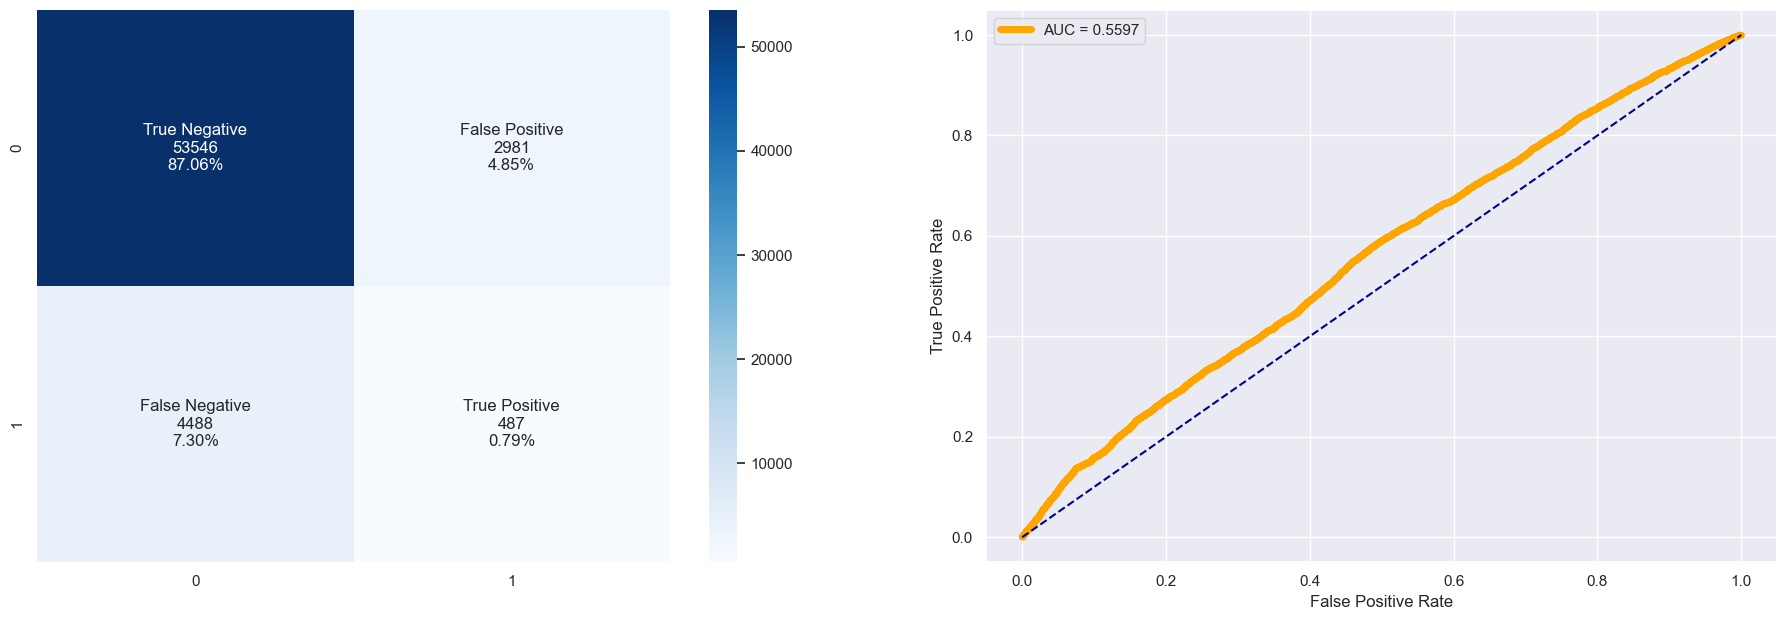

In [98]:
%time
# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
lr_name = 'LogisticRegression'

# Compute results 
lr_model, lr_results_cv, lr_results_val = train_model_with_cross_val(lr)

# Save logs
log_mlflow(lr_model, lr_name, params=lr_model.named_steps['classifier'].get_params(), business_score=lr_results_val['business'], 
           roc_auc=lr_results_val['roc_auc'], f1_score=lr_results_val['f1'], accuracy=lr_results_val['accuracy'],
           precision=lr_results_val['precision'], recall=lr_results_val['recall'], specificity=lr_results_val['specificity'],
           fpr=lr_results_val['fpr'], fitting_time=lr_results_val['fitting_time'])

##### RandomForest

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 2.15 µs


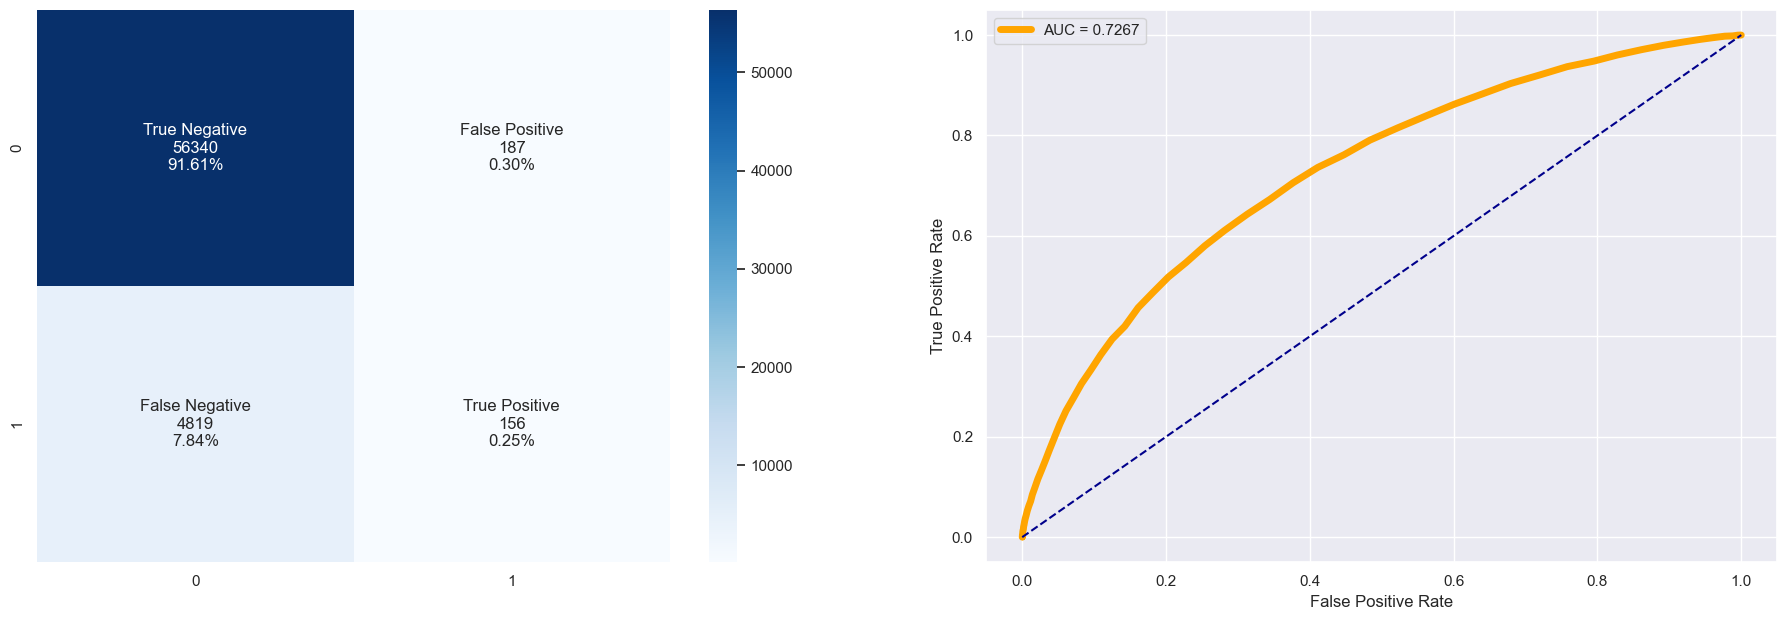

In [99]:
%time
# Create random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_name = 'RandomForest'

# Compute results 
rf_model, rf_results_cv, rf_results_val = train_model_with_cross_val(rf)

# Save logs
log_mlflow(rf_model, rf_name, params=rf_model.named_steps['classifier'].get_params(), business_score=rf_results_val['business'], 
           roc_auc=rf_results_val['roc_auc'], f1_score=rf_results_val['f1'], accuracy=rf_results_val['accuracy'],
           precision=rf_results_val['precision'], recall=rf_results_val['recall'], specificity=rf_results_val['specificity'],
           fpr=rf_results_val['fpr'], fitting_time=rf_results_val['fitting_time'])

##### XGBoost

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 11.7 µs


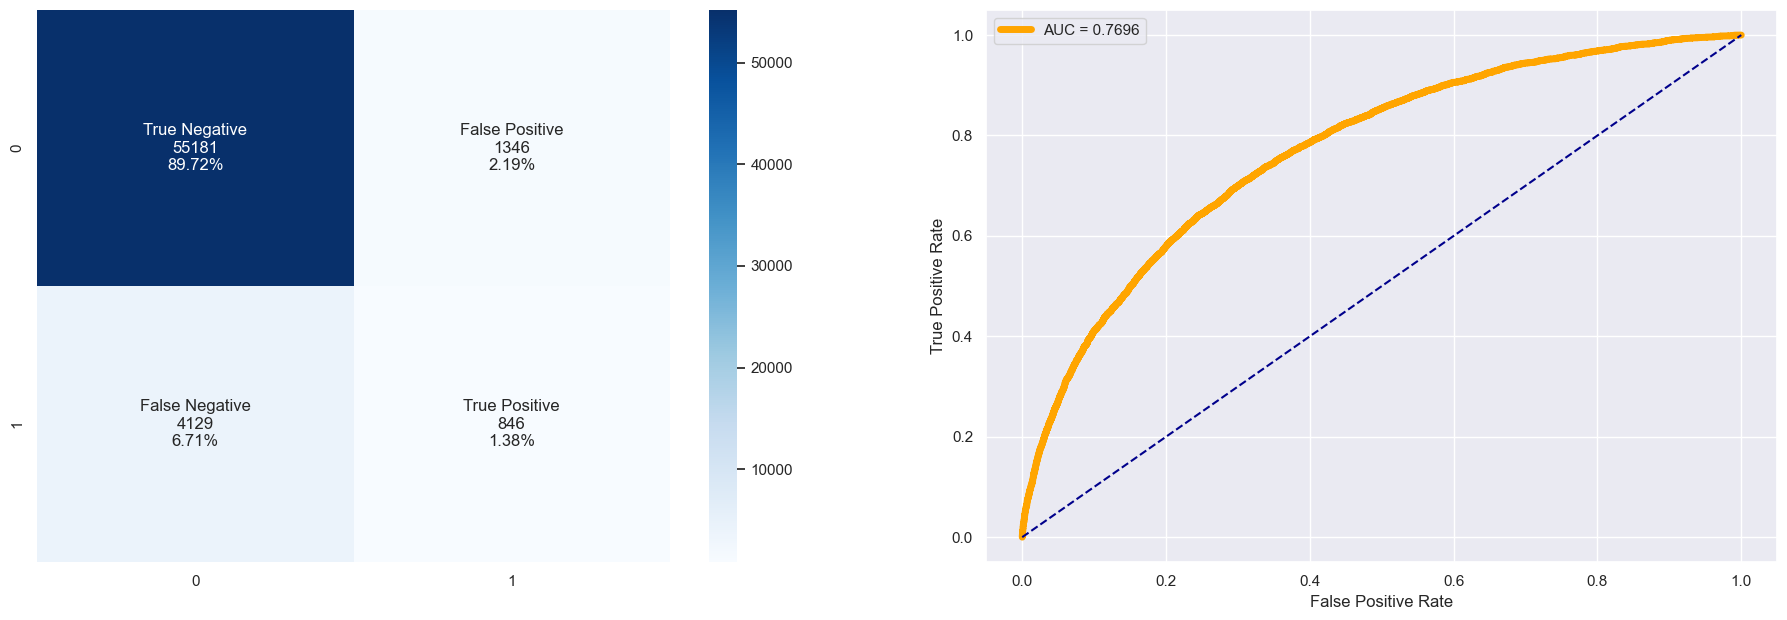

In [101]:
%time
# Create XGBoost classifier
xgbc = XGBClassifier(random_state=RANDOM_STATE, tree_method='auto', predictor='cpu_predictor')
xgbc_name = 'XGBoost'

# Compute results 
xgbc_model, xgbc_results_cv, xgbc_results_val = train_model_with_cross_val(xgbc)

# Save logs
log_mlflow(xgbc_model, xgbc_name, params=xgbc_model.named_steps['classifier'].get_params(), business_score=xgbc_results_val['business'], 
           roc_auc=xgbc_results_val['roc_auc'], f1_score=xgbc_results_val['f1'], accuracy=xgbc_results_val['accuracy'],
           precision=xgbc_results_val['precision'], recall=xgbc_results_val['recall'], specificity=xgbc_results_val['specificity'],
           fpr=xgbc_results_val['fpr'], fitting_time=xgbc_results_val['fitting_time'])

##### LightGBM

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 21 µs
[LightGBM] [Info] Number of positive: 56538, number of negative: 56538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.244589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114421
[LightGBM] [Info] Number of data points in the train set: 113076, number of used features: 515
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 56538, number of negative: 56538
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092707 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 114833
[LightGBM] [Info] Number of data points in the train set: 113076, number of used features:

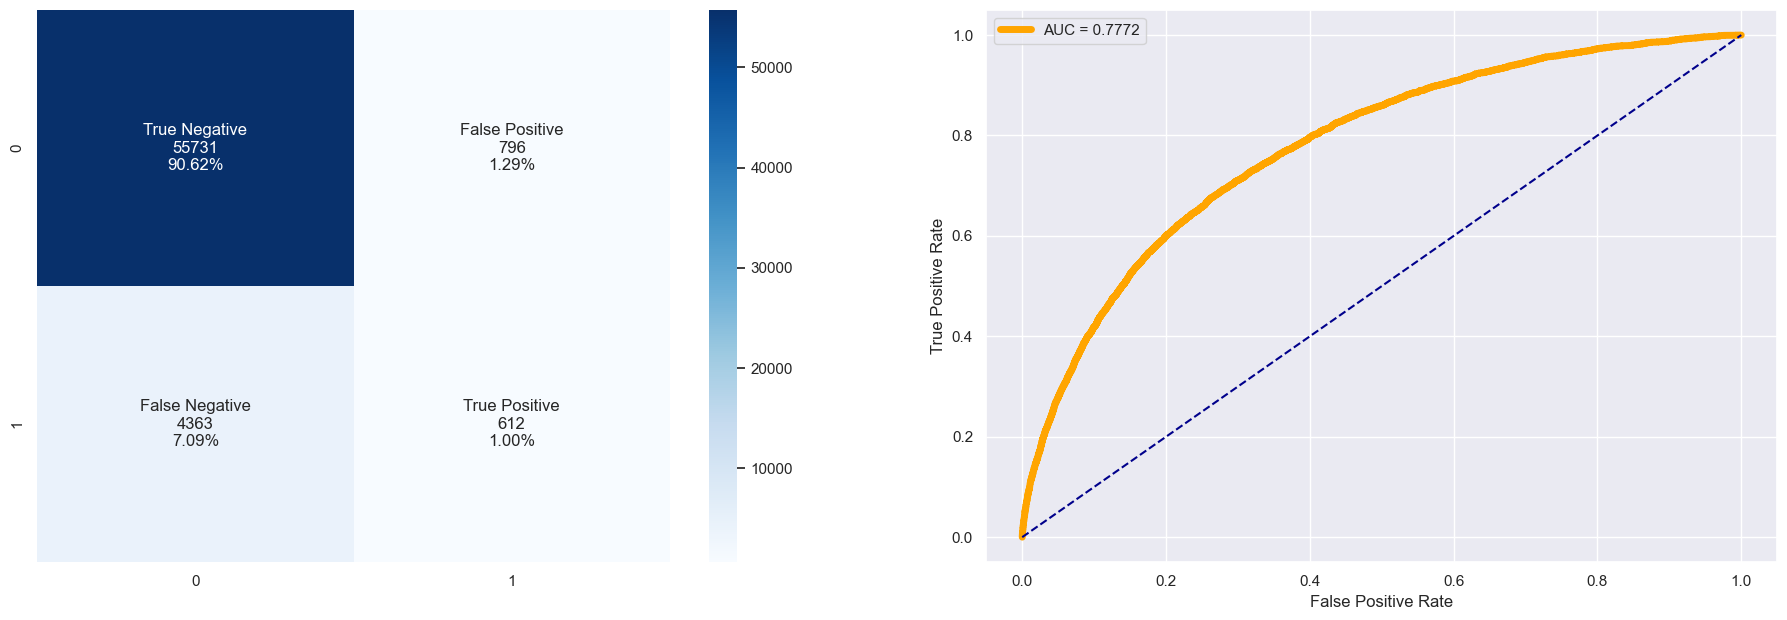

In [136]:
%time
# Create LightGBM classifier
lgbmc = LGBMClassifier(random_state=RANDOM_STATE, device='cpu', n_jobs=-1)
lgbmc_name = 'LightGBM'

# Compute results 
lgbmc_model, lgbmc_results_cv, lgbmc_results_val = train_model_with_cross_val(lgbmc)

# Save logs
log_mlflow(lgbmc_model, lgbmc_name, params=lgbmc_model.named_steps['classifier'].get_params(), business_score=lgbmc_results_val['business'], 
           roc_auc=lgbmc_results_val['roc_auc'], f1_score=lgbmc_results_val['f1'], accuracy=lgbmc_results_val['accuracy'],
           precision=lgbmc_results_val['precision'], recall=lgbmc_results_val['recall'], specificity=lgbmc_results_val['specificity'],
           fpr=lgbmc_results_val['fpr'], fitting_time=lgbmc_results_val['fitting_time'])



##### CatBoost

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 12.9 µs


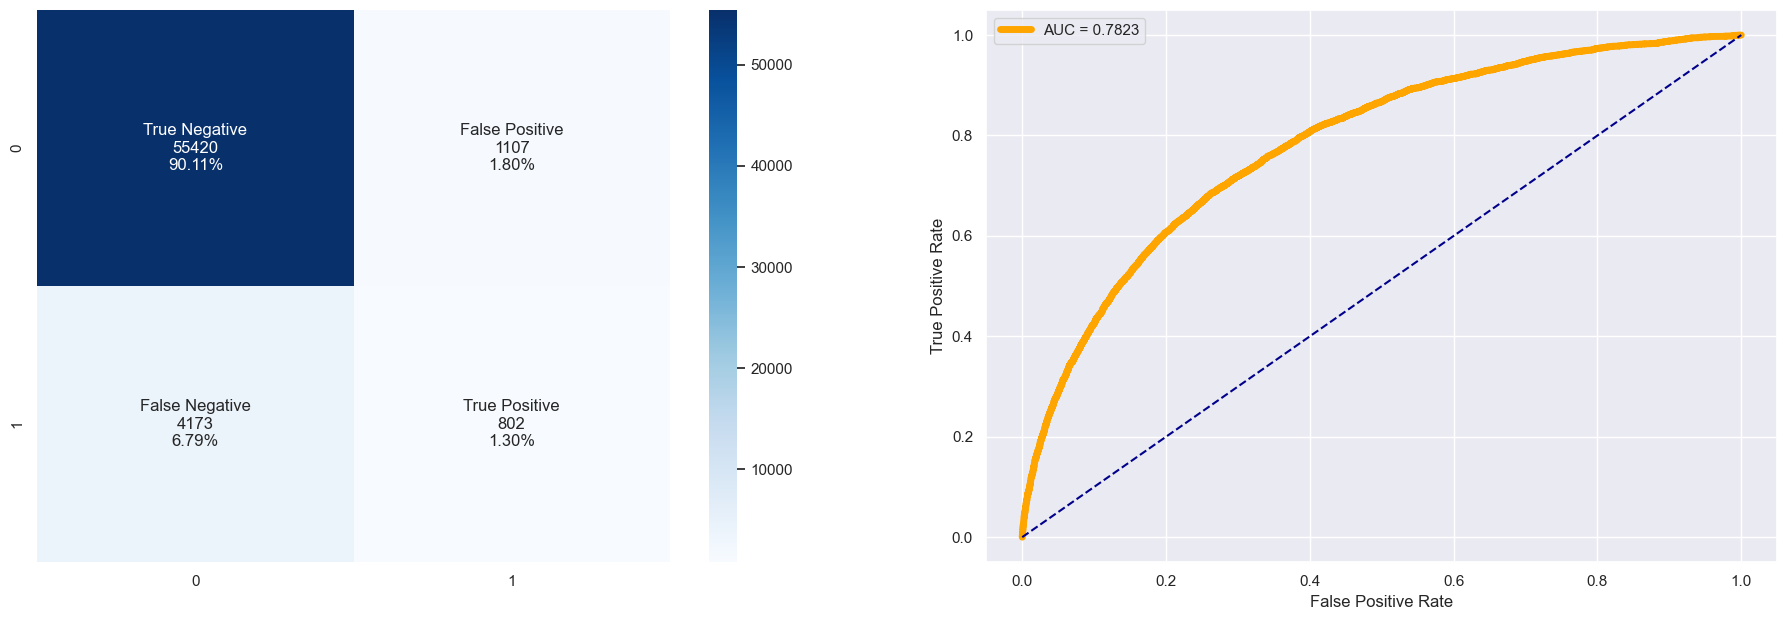

In [106]:
%time
# Create CatBoost classifier
cbc = CatBoostClassifier(random_state=RANDOM_STATE, task_type='CPU', logging_level='Silent')
cbc_name = 'CatBoost'

# Compute results 
cbc_model, cbc_results_cv, cbc_results_val = train_model_with_cross_val(cbc)

# Save logs
log_mlflow(cbc_model, cbc_name, params=cbc_model.named_steps['classifier'].get_params(), business_score=cbc_results_val['business'], 
           roc_auc=cbc_results_val['roc_auc'], f1_score=cbc_results_val['f1'], accuracy=cbc_results_val['accuracy'],
           precision=cbc_results_val['precision'], recall=cbc_results_val['recall'], specificity=cbc_results_val['specificity'],
           fpr=cbc_results_val['fpr'], fitting_time=cbc_results_val['fitting_time'])